### This notebook allows to analyze results of clustering with approach based on time windows.

1) The first part prepares necessary data.

2) The second one produces .csv files with most relevant risk factors per each issuer cluster in each time window.

3) The third part produces plots of risk factors curves with cluster assignment in each time window highlighted via colors.

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../Modules')
from ts_correlation import *
from variation_information import *
from utils_clustering import *
from utils_clustering_time_windows import *
from preprocess_series import *
from analysis_clustering_time_windows import *
from read_prepare_input_clustering import *
from tsmoothie.smoother import *
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance

In [2]:
## PARAMETERS

# Number of days in each time window
window_shape = 90

# Class used to scale time series data
# - TimeSeriesScalerMinMax(): scaling each series between min and max value
# - TimeSeriesScalerMeanVariance(): scaling each series to have mean mu and unitary standard deviation
# - None for no scaling
time_series_scaler = TimeSeriesScalerMeanVariance()

In [3]:
# Read input data

df_all, df_all_lookup, obs_universe_fx, obs_universe_local, risk_factors_to_include = import_data_clustering_issuer_rf()
clustering_results_curves = pd.read_csv('../Output/4.3_Clustering_Results/res_tw_autoencoder_1.csv', sep=';')
clustering_results_rf = pd.read_csv('../Output/4.3_Clustering_Results/clust_rf_time_windows_autoencoder.csv', sep=';')
risk_factors_to_include = list(clustering_results_rf['curveId'])
mapping_rf_names = pd.read_csv('../Data/RiskFactor_Local_FX_20220606.csv', sep=';')

In [5]:
# Set short name of risk factors as columns of df with observations of local risk factors in time

new_cols_local_rf = list(pd.DataFrame({'complete_name': obs_universe_local.columns}).\
    merge(mapping_rf_names, how='left').\
    assign(short_name = lambda x: np.where(pd.isna(x['short_name']), x['complete_name'], x['short_name']))\
    ['short_name'])
obs_universe_local.columns=new_cols_local_rf

In [6]:
# Remove series having more than 90% NA values

df_all_lookup_complete = remove_series_mostly_na(df_all_lookup, 0.9)
obs_universe_local = remove_series_mostly_na(obs_universe_local, 0.9)
obs_universe_fx = remove_series_mostly_na(obs_universe_fx, 0.9)

print('Min date in observation universe fx: ' + str(min(obs_universe_fx.index)))
print('Max date in observation universe fx: ' + str(max(obs_universe_fx.index)))
print('\n')

print('Min date in observation universe local: ' + str(min(obs_universe_local.index)))
print('Max date in observation universe local: ' + str(max(obs_universe_local.index)))
print('\n')

print('Min date in curves df: ' + str(min(df_all_lookup_complete.index)))
print('Max date in curves df: ' + str(max(df_all_lookup_complete.index)))

min_dates = [min(obs_universe_fx.index), min(obs_universe_local.index), min(df_all_lookup_complete.index)]
max_dates = [max(obs_universe_fx.index), max(obs_universe_local.index), max(df_all_lookup_complete.index)]

# Min and max dates for which we have all data available
lb_dates = max(min_dates)
ub_dates = min(max_dates)

df_all_lookup_filtered = df_all_lookup_complete[(df_all_lookup_complete.index >= lb_dates) & 
                                                (df_all_lookup_complete.index <= ub_dates)]
df_universe_fx_filtered = obs_universe_fx[(obs_universe_fx.index >= lb_dates) &
                                          (obs_universe_fx.index <= ub_dates)]
df_universe_local_filtered = obs_universe_local[(obs_universe_local.index >= lb_dates) &
                                                (obs_universe_local.index <= ub_dates)]

df_risk_factors = pd.concat([df_universe_fx_filtered, df_universe_local_filtered], axis=1)
risk_factors_to_include_available = list(set(df_risk_factors.columns).intersection(set(risk_factors_to_include)))
df_risk_factors = df_risk_factors[risk_factors_to_include_available]

# Merge df with curves and df with risk factors
df_complete = df_all_lookup_filtered.merge(df_risk_factors, left_index=True, right_index=True)

Maximum Timestamp of available data point 2015-05-21 00:00:00
Minimum Timestamp of not null data point cross time series 2021-12-06 00:00:00
Maximum Timestamp of available data point 2015-05-15 00:00:00
Minimum Timestamp of not null data point cross time series 2022-05-13 00:00:00
Maximum Timestamp of available data point 2015-05-15 00:00:00
Minimum Timestamp of not null data point cross time series 2022-05-13 00:00:00
Min date in observation universe fx: 2015-05-15 00:00:00
Max date in observation universe fx: 2022-05-13 00:00:00


Min date in observation universe local: 2015-05-15 00:00:00
Max date in observation universe local: 2022-05-13 00:00:00


Min date in curves df: 2015-05-21 00:00:00
Max date in curves df: 2021-12-06 00:00:00


In [7]:
# Generate time windows for all series in the dataframe
# Time windows are disjoint, there is no overlapping between two different windows generated from the same series

df_transposed = df_complete.T
df_transposed.shape

# Generate time windows for all series in the dataframe
# Time windows are disjoint, there is no overlapping between two different windows generated from the same series
window_values = split_series_in_time_windows(df_transposed, window_shape, time_series_scaler=time_series_scaler,
                                             return_smooth=False)

In [8]:
# Define first and last day of each time window

# Compute time windows start and end dates
time_windows, string_time_windows = get_time_windows_bounds(df_transposed, window_shape)

# Build dataframe with series divided in time windows
curve_ids = list(df_transposed.index)
curve_ids = [ele for ele in curve_ids for i in range(len(time_windows))]
tws = [ele for i in range(len(df_transposed.index)) for ele in list(string_time_windows.values())]
window_values_df = pd.DataFrame(np.squeeze(window_values)).assign(curveId = curve_ids, time_window = tws)

## Identify most relevant risk factors per each issuer cluster

Per each time window, build a .csv file with the most relevant risk factor per each issuer cluster.

Most relevant risk factors are identified according to the following procedure, which is carried out independently per each time window:

1) Per each issuer curve, identify the top k closest risk factors to the issuer curve in terms of corr-based distance

2) Per each issuers' cluster, identify as most relevant risk factors those appearing in the top k for at least "threshold_perc" of the issuer curves in that cluster

In [34]:
clustering_results_rf.columns = [*[clustering_results_rf.columns[0]],
                                *list(string_time_windows.values())]
clustering_results_curves.columns = [*[clustering_results_curves.columns[0]],
                                     *list(string_time_windows.values())]

In [40]:
k = 5
threshold_perc = 0.5

for i in string_time_windows:
    tw = string_time_windows[i]
    clust_rf_tw = clustering_results_rf.loc[:, ['curveId', tw]].rename(columns={tw: 'cluster_label'})
    top_rf_curr_tw = top_rf_per_cl(window_values_df, tw, k, risk_factors_to_include_available,
                 df_all_lookup_filtered.columns, clustering_results_curves).T.reset_index().rename(columns={'index': 'curveId'}).\
        merge(clust_rf_tw)

    issuer_cluster_list = np.sort(np.array(clustering_results_curves.loc[:, tw].unique()))
    result_curr_tw = pd.DataFrame()
    for cl in issuer_cluster_list:

        dim_cluster = clustering_results_curves.loc[lambda x: x[tw] == cl].shape[0]
        temp = top_rf_curr_tw.sort_values(by=[cl, 'curveId'], ascending=False)[['curveId', 'cluster_label', cl]].\
            rename(columns={'curveId': 'risk_factor', 'cluster_label': 'rf_cluster', cl: 'percentage'})
        temp = temp.assign(issuer_cluster=cl, dim_issuer_cluster=dim_cluster)\
            [['issuer_cluster', 'dim_issuer_cluster', 'risk_factor', 'percentage', 'rf_cluster']].\
            loc[lambda x: x['percentage'] >= threshold_perc]
        result_curr_tw = pd.concat([result_curr_tw, temp], ignore_index=True)
        
    result_curr_tw.to_csv('../Output/4.3_Clustering_Results/Most_Relevant_RiskFactors_Tw_Autoencoder/relevant_rf_tw_' + str(i+1) + '.csv', sep=';', index=False)

## Plot risk factors curves highlighting cluster label in each time window

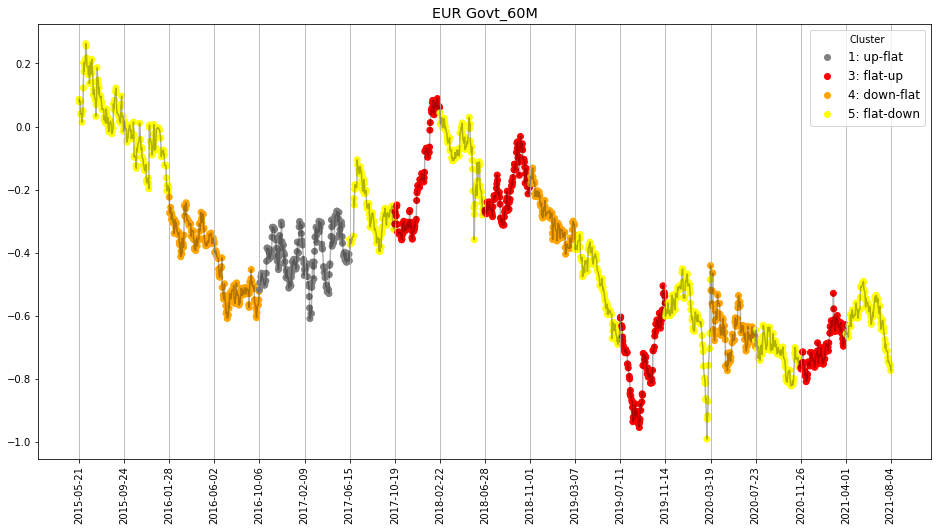

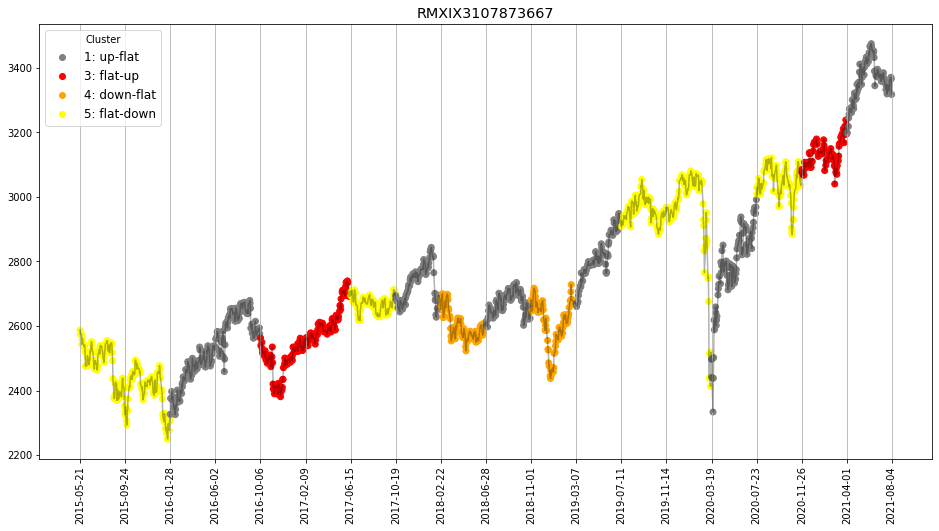

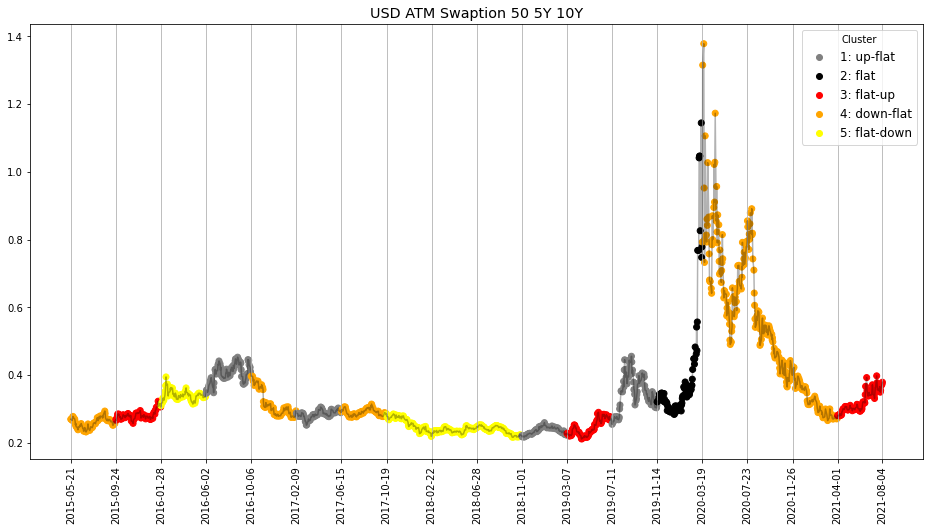

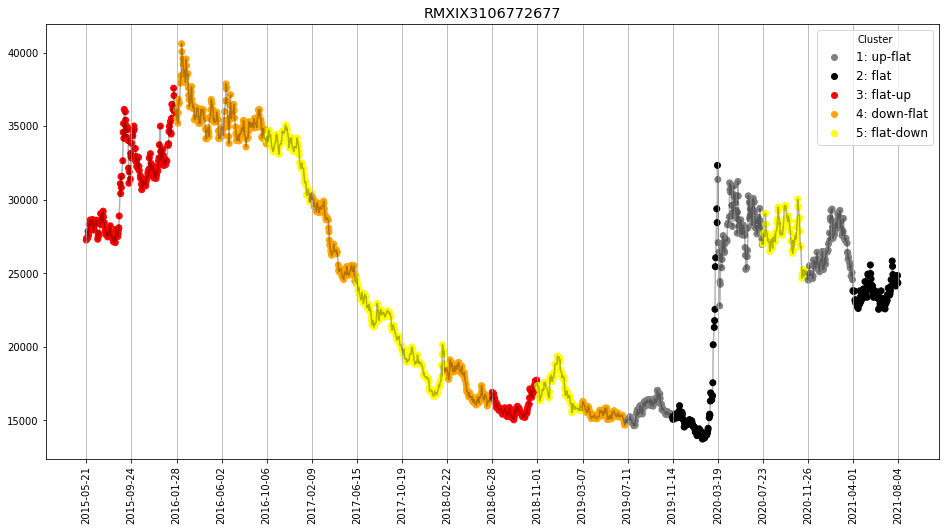

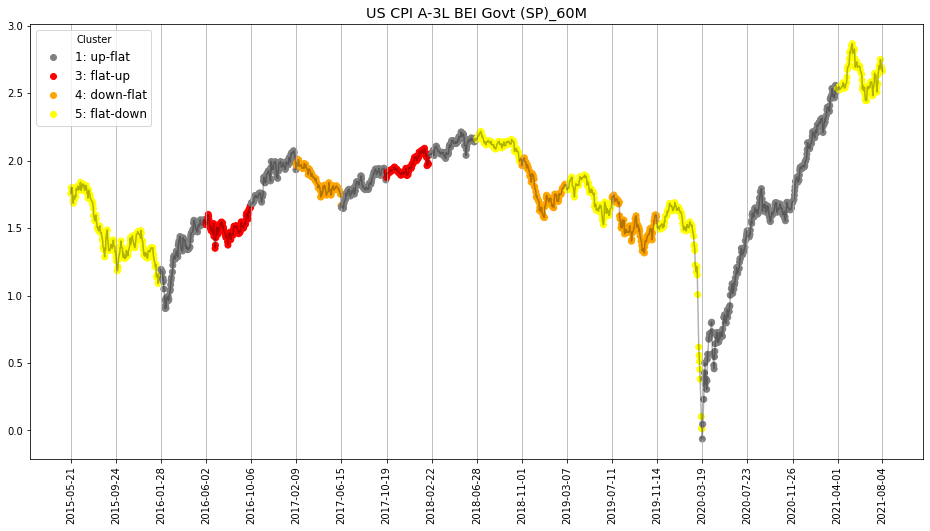

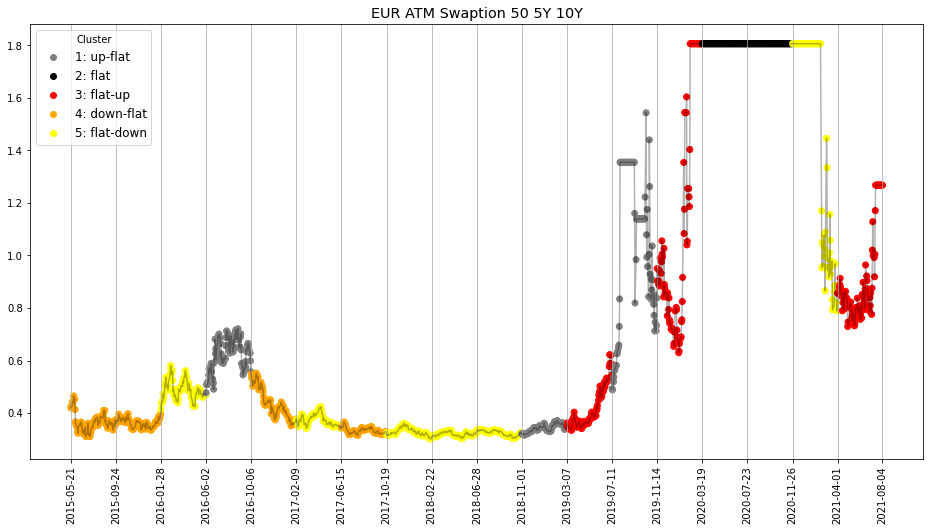

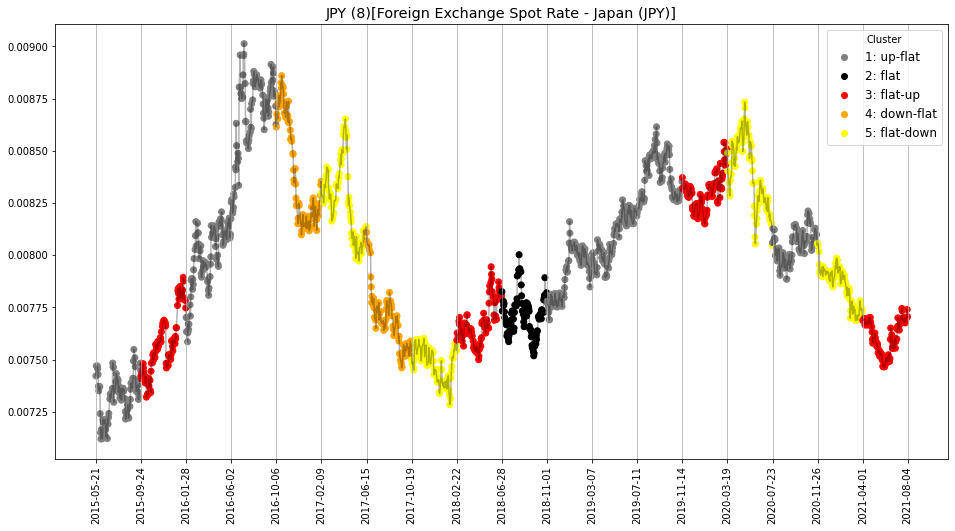

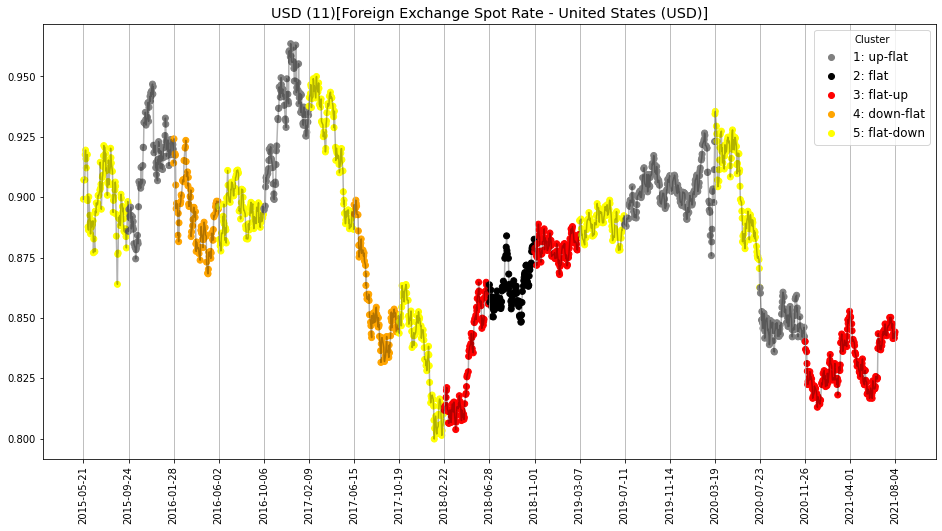

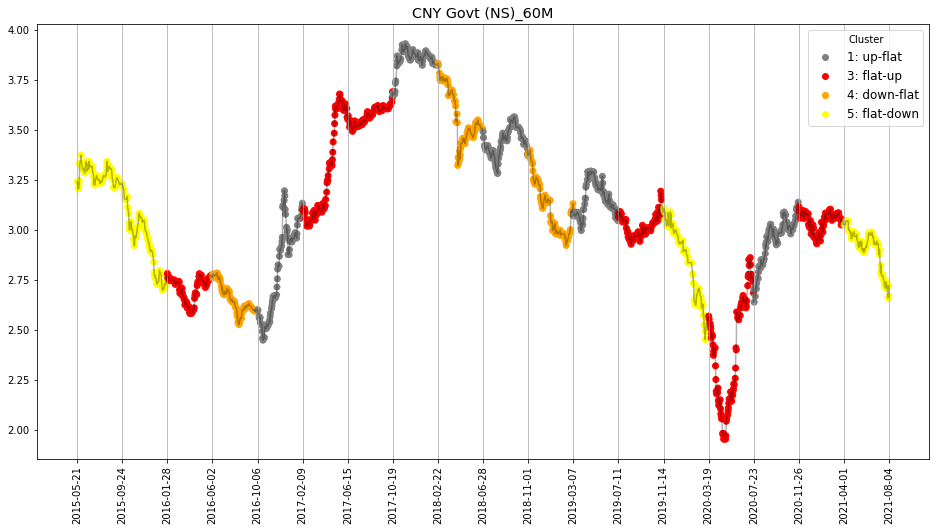

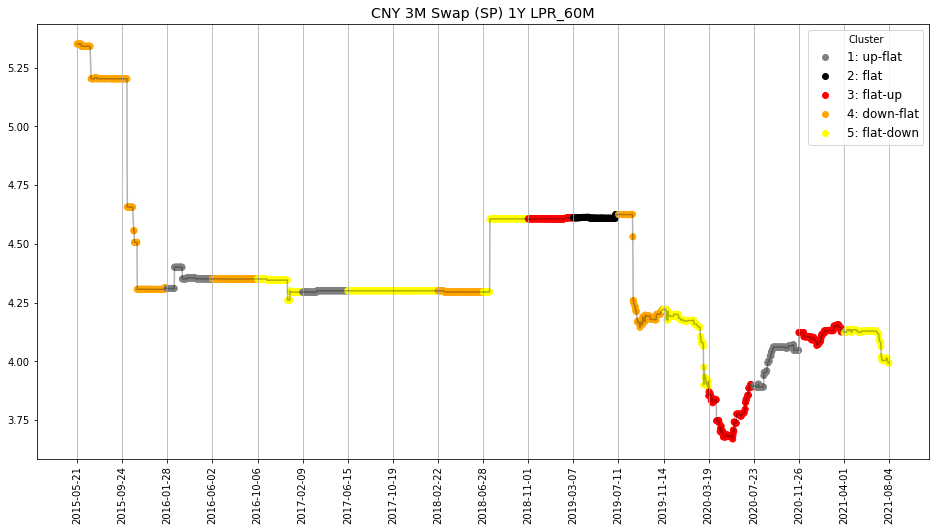

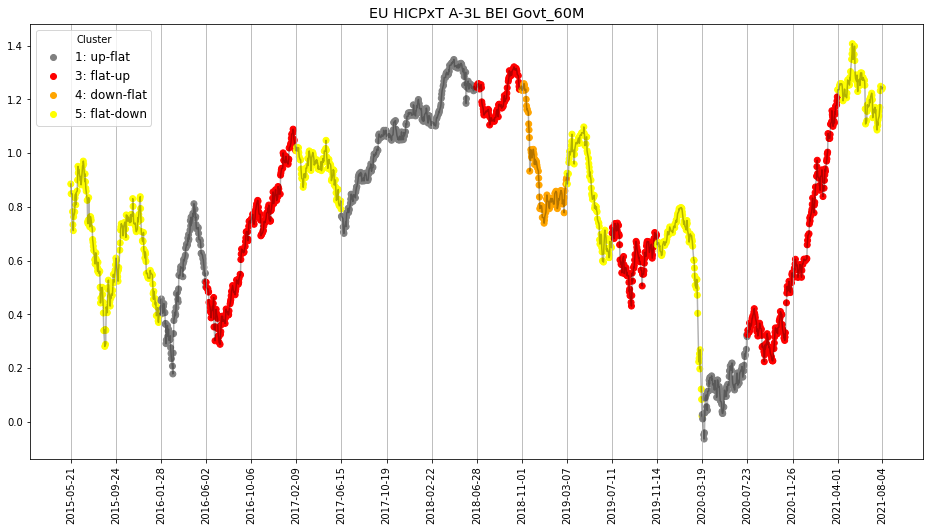

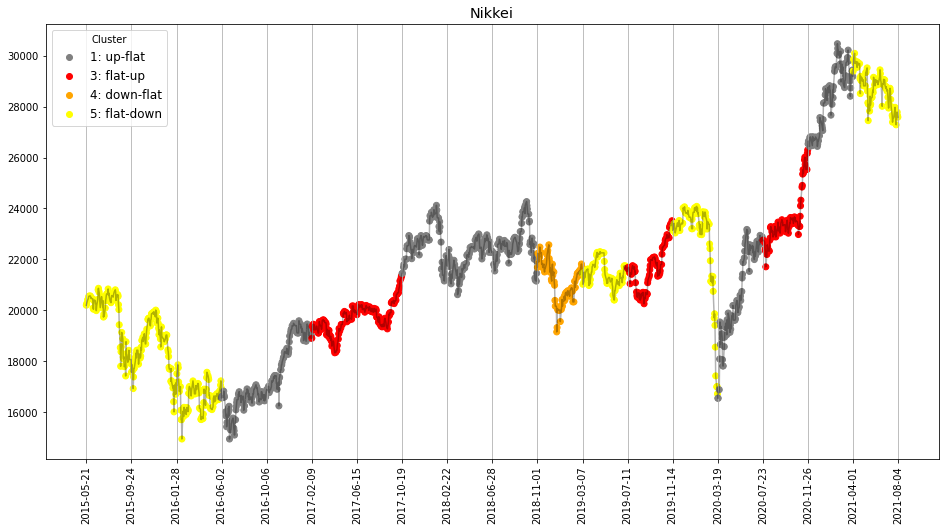

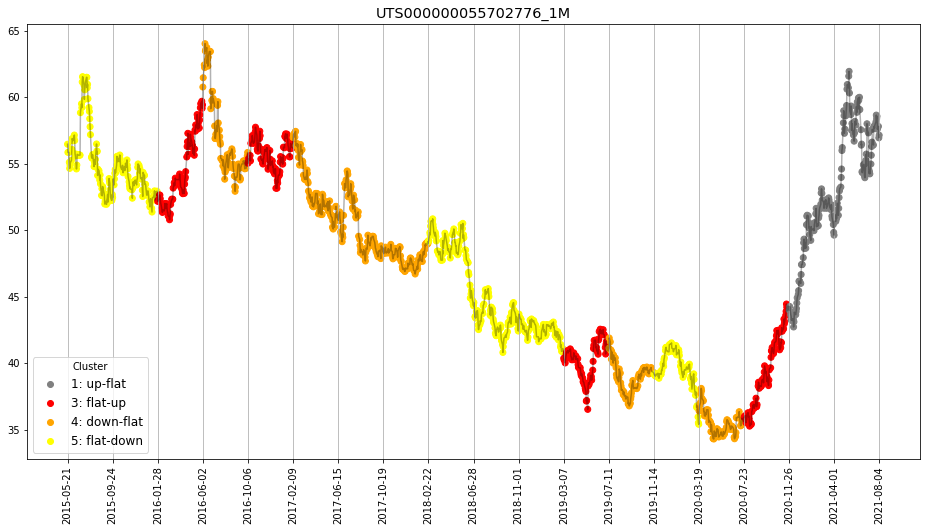

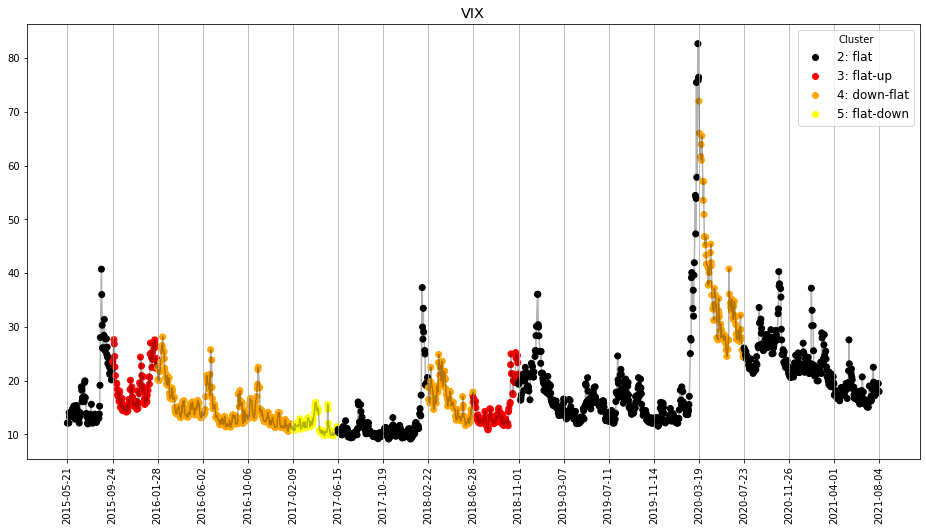

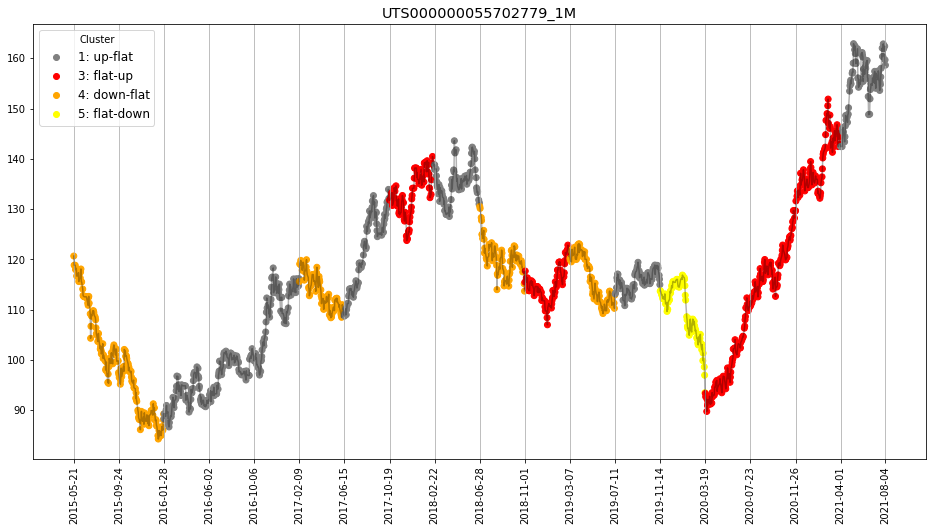

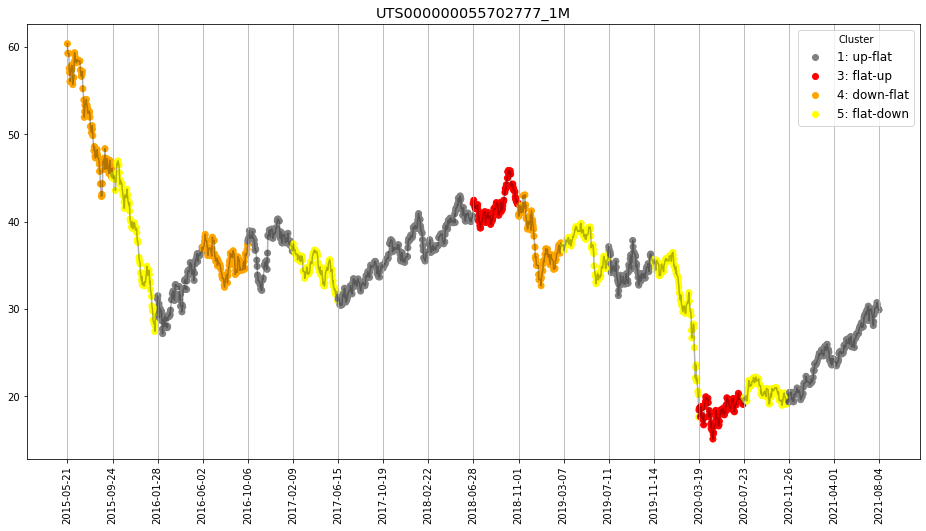

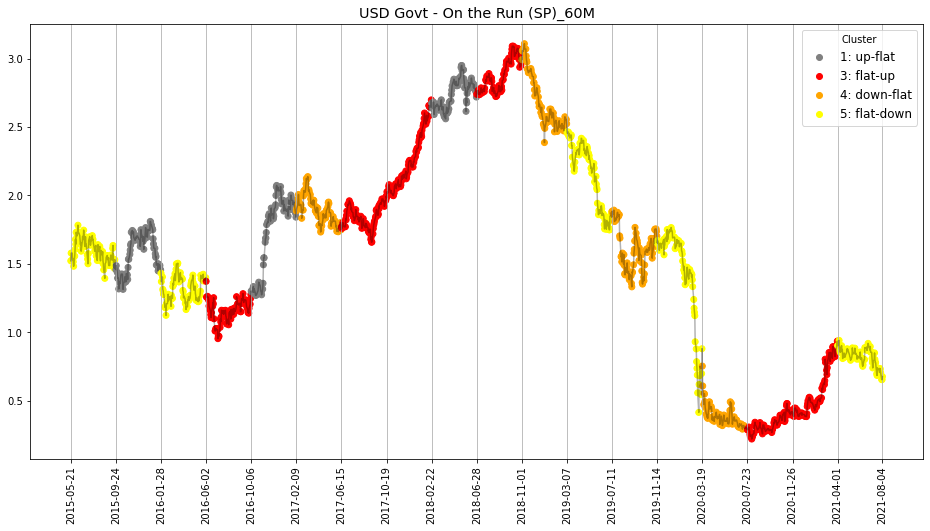

In [15]:
plot_series_tw_clustering(df_risk_factors, time_windows, window_shape, clustering_results_rf,
                         colors = cls.ListedColormap(['grey', 'black', 'blue', 'red', 'orange', 'yellow']),
                         cluster_patterns = {1:'1: up-flat', 2:'2: flat', 3:'3: flat-up',
                                             4:'4: down-flat', 5:'5: flat-down'},
#                           cluster_patterns = {0:'0: flat-down', 1:'1: down-flat', 2:'2: S',
#                                              3:'3: V', 4:'4: up-flat', 5:'5: oscillating-down'},
#                          output_path = '../Output/4.3_Clustering_Results/RiskFactor_Series_Tw_Clusters/')
                          output_path = None)